# Predicting Apple Stock Prices Using LSTM #

## (a)Problem Statement

The goal of this project is to build a Long Short-Term Memory (LSTM) model to predict the stock prices of Apple Inc. for the year 2021. We will use historical stock price data to train the model and evaluate its performance using the Root Mean Squared Error (RMSE). Additionally will extend the model to predict stock prices for the year 2022 and visualize the results.

About Dataset:

The dataset captures the historical stock price information for Apple Inc., offering a comprehensive perspective on the company's financial performance over time. Each record corresponds to a specific date, beginning from December 12, 1980, to June 17, 2022. Here's a breakdown of the dataset columns:

Date: The date of the stock price record, providing a chronological timeline for the dataset.
Open: The opening price, representing the initial trading price of Apple Inc.'s stock on a given day.
High: The highest stock price during a specific period, providing insights into peak price levels.
Low: The lowest stock price observed during a defined period, indicating potential fluctuations in value.
Close: The closing price, representing the last recorded price at the end of a regular trading session.
Adj Close (Adjusted Close): Adjusts the closing price for corporate actions, offering a more accurate representation of the stock's true value.
Volume: Measures the number of shares traded, providing insights into interest and activity in Apple Inc.'s stock.
The dataset spans several decades, making it a valuable resource for various analytical purposes, including trend identification, volatility evaluation, and predictive modeling like the ongoing LSTM-based stock price prediction exploration. This dataset contributes significantly to understanding Apple Inc.'s stock performance in the dynamic financial landscape.

## (b) Algorithm of the Solution

### Step 1: Import Libraries
imported necessary libraries for data manipulation, visualization, preprocessing, and building the LSTM model.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import seaborn as sns

### Step 2: Load and Preprocess Data

loaded the dataset and preprocess it by converting the 'Date' column to datetime format and setting it as the index. This helps in handling time series data more efficiently.

In [114]:
# Load the dataset 
df = pd.read_csv('/Users/rameshchidurala/Documents/DSC-550 Assignments/AAPL.csv')

# Display the first few rows of the dataset
print(df.head())

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600


In [115]:
# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())


Checking for missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [122]:
df.shape

(10468, 6)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10468 entries, 1980-12-12 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10468 non-null  float64
 1   High       10468 non-null  float64
 2   Low        10468 non-null  float64
 3   Close      10468 non-null  float64
 4   Adj Close  10468 non-null  float64
 5   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 572.5 KB


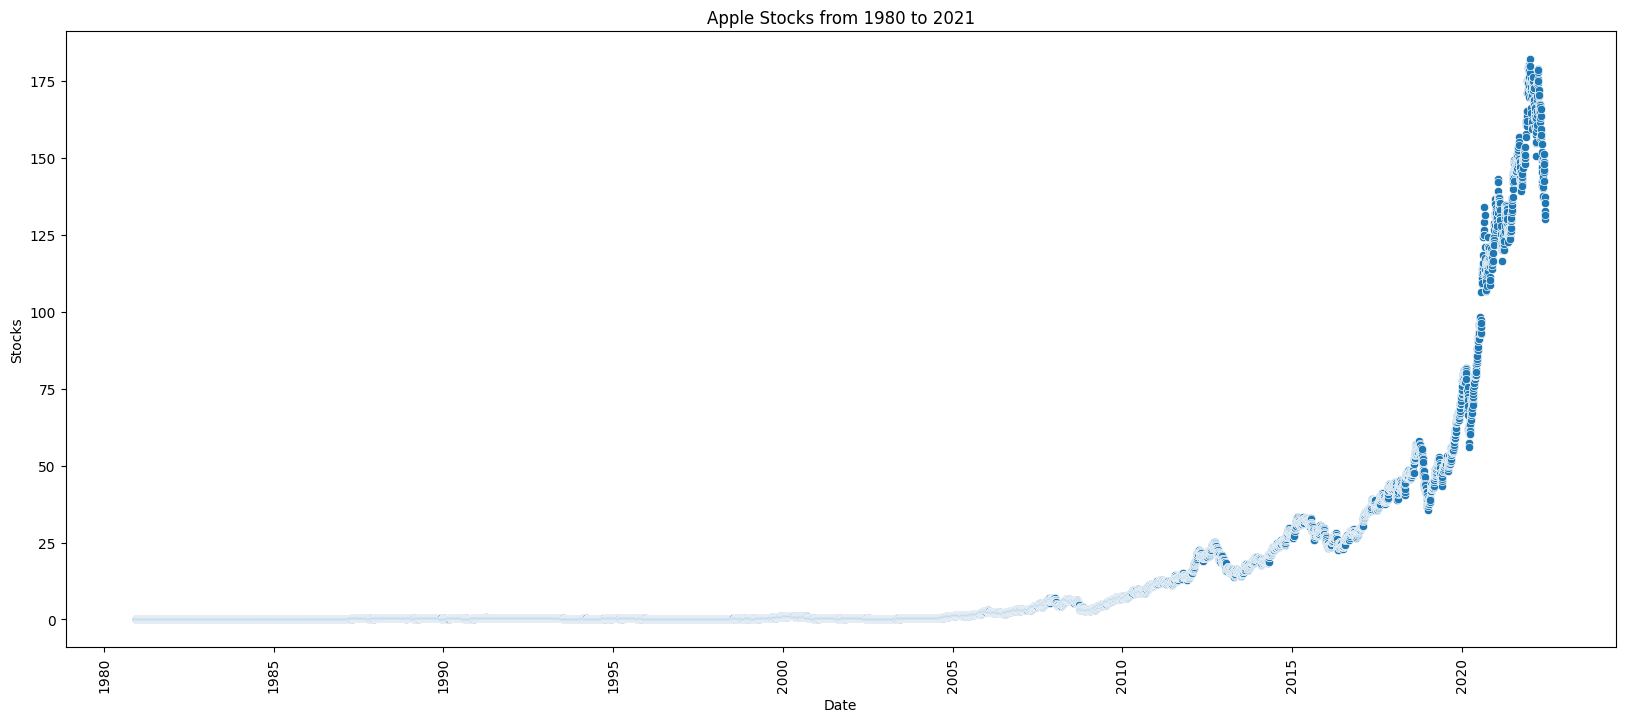

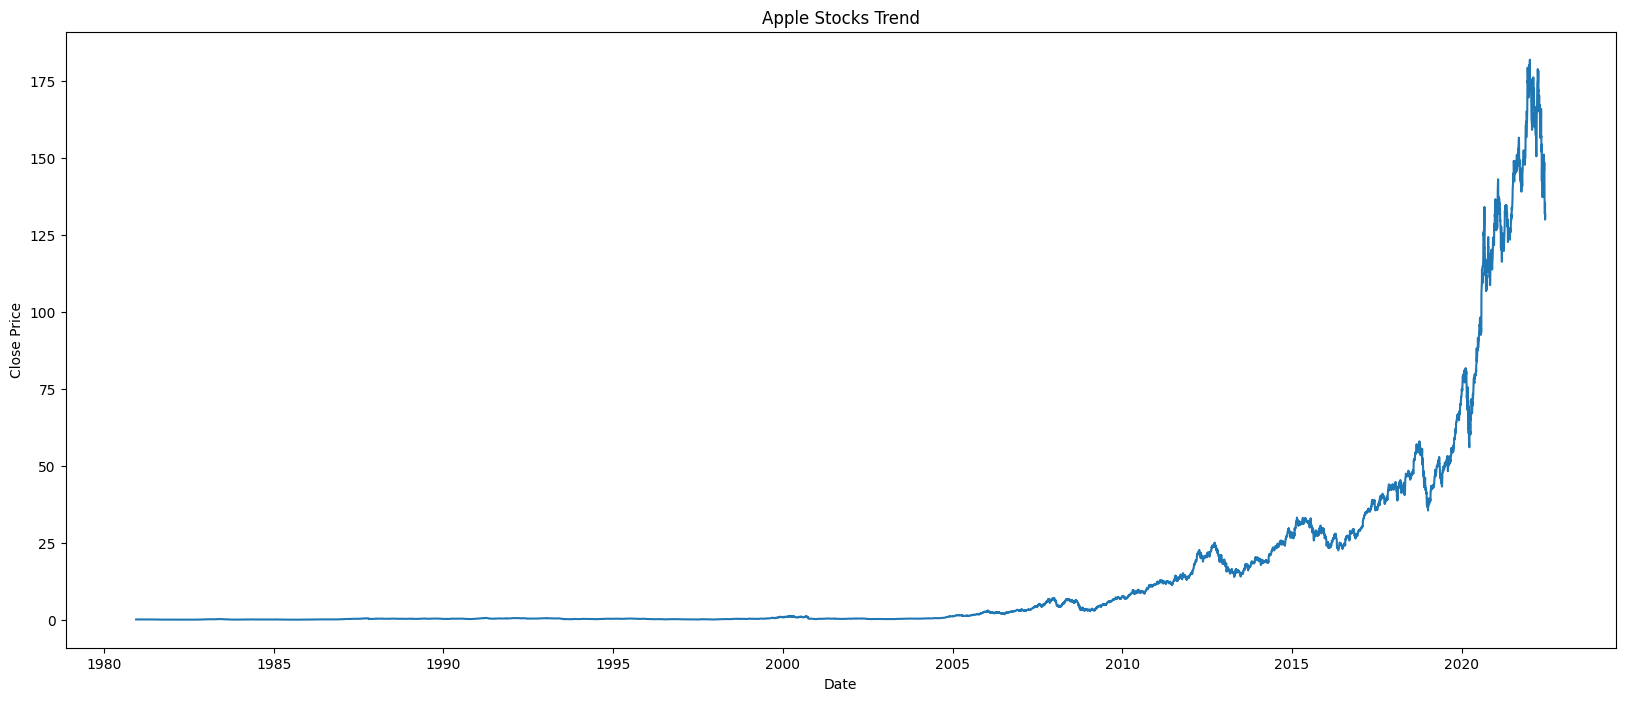

In [116]:
# Convert 'Date' to datetime format and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plotting Scatter Plot
plt.figure(figsize=(20, 8))
sns.scatterplot(data=df, x=df.index, y='Close')
plt.title('Apple Stocks from 1980 to 2021')
plt.ylabel('Stocks')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

# Plotting Time Series Trend
plt.figure(figsize=(20, 8))
plt.plot(df['Close'])
plt.title('Apple Stocks Trend')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()


### Step 3: Normalize the Data

Normalized the 'Close' prices to a range between 0 and 1 using MinMaxScaler. This is a common preprocessing step for neural networks to improve convergence.

In [117]:
# Extract the 'Close' column for further analysis
closing_prices = df.filter(['Close']).values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)


### Step 4: Create Training and Testing Data

We split the data into training and testing sets, with 95% of the data used for training and the remaining 5% for testing which is the recent data of 2021. We then generate sequences of 60 timesteps for training the LSTM model.

In [124]:
# Create training dataset
train_data = scaled_prices[:int(len(scaled_prices) * 0.95), :]
train_features, train_labels = [], []

# Prepare training data
for i in range(60, len(train_data)):
    train_features.append(train_data[i-60:i, 0])
    train_labels.append(train_data[i, 0])

train_features, train_labels = np.array(train_features), np.array(train_labels)

# Reshape the data for LSTM
train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))

In [125]:
train_features

array([[[4.35483696e-04],
        [3.98684579e-04],
        [3.49613594e-04],
        ...,
        [3.58813373e-04],
        [3.09747884e-04],
        [2.82143050e-04]],

       [[3.98684579e-04],
        [3.49613594e-04],
        [3.64946559e-04],
        ...,
        [3.09747884e-04],
        [2.82143050e-04],
        [2.60676899e-04]],

       [[3.49613594e-04],
        [3.64946559e-04],
        [3.83351613e-04],
        ...,
        [2.82143050e-04],
        [2.60676899e-04],
        [2.82143050e-04]],

       ...,

       [[4.29836273e-01],
        [4.09406064e-01],
        [3.95529450e-01],
        ...,
        [4.22417102e-01],
        [4.25013836e-01],
        [4.22499537e-01]],

       [[4.09406064e-01],
        [3.95529450e-01],
        [4.01808278e-01],
        ...,
        [4.25013836e-01],
        [4.22499537e-01],
        [4.32460469e-01]],

       [[3.95529450e-01],
        [4.01808278e-01],
        [3.75525151e-01],
        ...,
        [4.22499537e-01],
        [4.3246

In [126]:
# Create the testing dataset
test_data = scaled_prices[int(len(scaled_prices) * 0.95) - 60:, :]
x_test, y_test = [], closing_prices[int(len(closing_prices) * 0.95):, :]

# Prepare testing data
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
test_data, x_test

(array([[0.40180828],
        [0.37552515],
        [0.37530532],
        [0.41027164],
        [0.39723314],
        [0.41567115],
        [0.40217926],
        [0.39683469],
        [0.36542686],
        [0.39176492],
        [0.37814935],
        [0.34077868],
        [0.38163912],
        [0.33250769],
        [0.34713995],
        [0.33863537],
        [0.33603866],
        [0.31468792],
        [0.30799691],
        [0.3389239 ],
        [0.33705537],
        [0.35480644],
        [0.34010547],
        [0.34981909],
        [0.34910464],
        [0.33072159],
        [0.33624474],
        [0.33140855],
        [0.36034333],
        [0.3561666 ],
        [0.36528946],
        [0.36792737],
        [0.37515421],
        [0.39411431],
        [0.39051464],
        [0.39361972],
        [0.38827514],
        [0.38021023],
        [0.36844947],
        [0.3790699 ],
        [0.37759979],
        [0.38850873],
        [0.38878353],
        [0.38247719],
        [0.39504861],
        [0

In [121]:
# Check the lengths of training and testing data
print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 9944
Testing data length: 584


### Step 5: Build and Train the LSTM Model

Build the LSTM model with three LSTM layers and dropout layers to prevent overfitting. The model is compiled with the Adam optimizer and mean squared error loss function, and then trained for 75 epochs.

In [99]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Fit the model to the training data
model.fit(train_features, train_labels, epochs=75, batch_size=32)


Epoch 1/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 7.7700e-04
Epoch 2/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 7.3951e-05
Epoch 3/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 6.5140e-05
Epoch 4/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 4.5708e-05
Epoch 5/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 4.1595e-05
Epoch 6/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.8637e-05
Epoch 7/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.5527e-05
Epoch 8/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.6607e-05
Epoch 9/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 4.2342e-05
Epoch 10/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.7672e-05
Epoch 11/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 2.8913e-05
Epoch 12/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 3.2988e-05
Epoch 13/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 2.7224e-05
Epoch 14/75
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - los

In [112]:
# Save the trained model
model.save('apple_stock_lstm_model.h5')

### Step 6: Evaluate the Model

Evaluated the model by predicting the stock prices on the test set and calculating the RMSE and also visualize the predicted prices against the actual prices.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/var/folders/kw/dtj9__8n4qv9bxydv0cs61380000gn/T/ipykernel_9955/2944658303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['Predictions'] = predictions


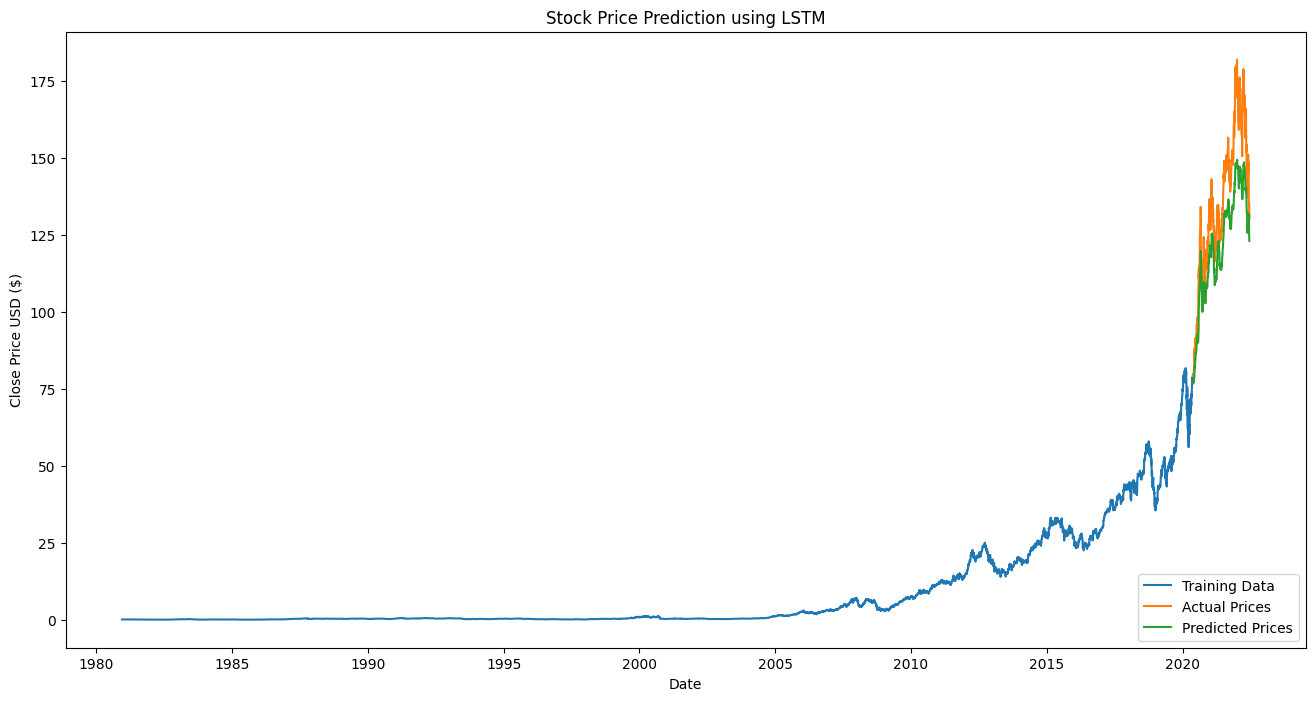

In [110]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Create a DataFrame for training and validation data
training_set = df.iloc[:int(len(closing_prices) * 0.95)]
validation_set = df.iloc[int(len(closing_prices) * 0.95):]
validation_set['Predictions'] = predictions

# Visualize the predicted prices compared to actual prices
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(training_set['Close'], label='Training Data')
plt.plot(validation_set[['Close', 'Predictions']], label=['Actual Prices', 'Predicted Prices'])
plt.legend(loc='lower right')
plt.show()

In [111]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 15.876380182662139


### Step 7: Predict Future Prices for 2022
Considered the most recent data from the test set to predict future stock prices for 2022 and created a function predict_future to generate future predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

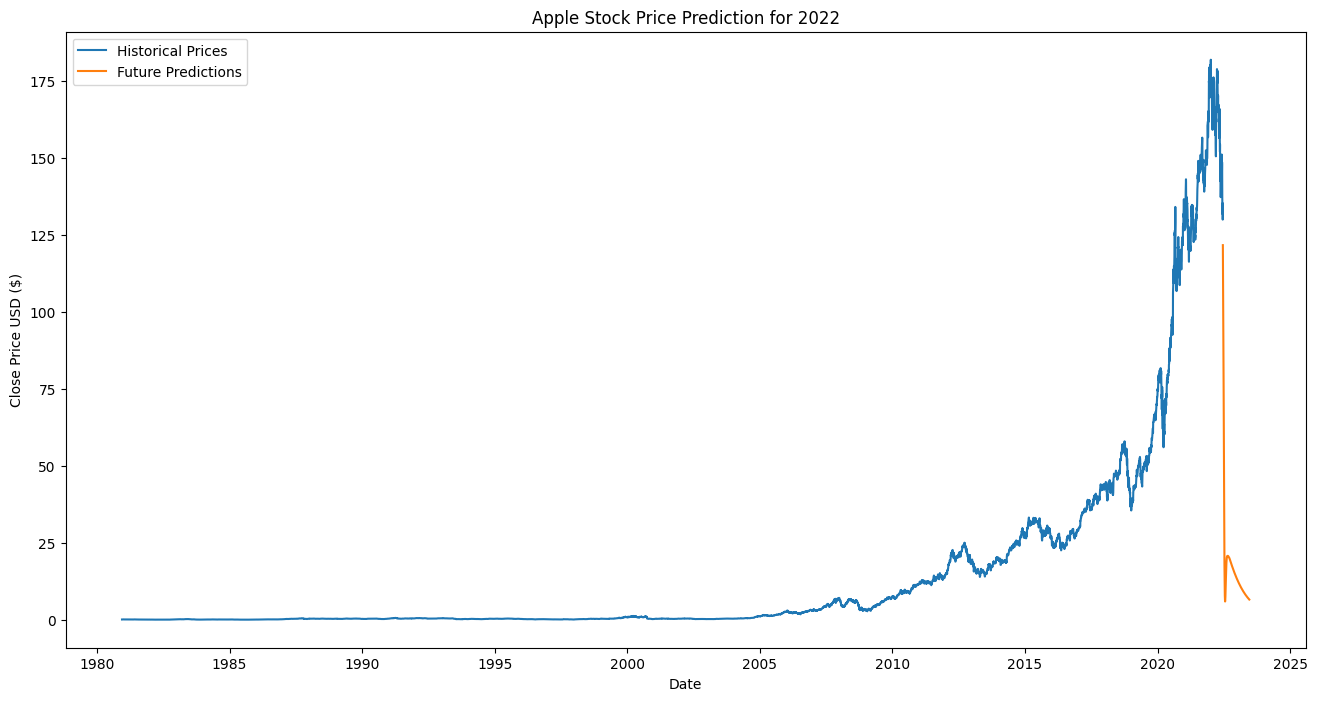

In [103]:
# Predict future prices for 2022
def predict_future(data, model, scaler, steps):
    data_copy = data.copy()
    future_predictions = []
    for _ in range(steps):
        last_sequence = data_copy[-60:]
        last_sequence = last_sequence.reshape((1, last_sequence.shape[0], 1))
        next_pred = model.predict(last_sequence)
        future_predictions.append(next_pred[0, 0])
        data_copy = np.append(data_copy, next_pred)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# Predict 365 future steps (1 year)
future_steps = 365
future_predictions = predict_future(test_data, model, scaler, future_steps)

# Plot future predictions
future_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, inclusive='right')

plt.figure(figsize=(16, 8))
plt.plot(df.index, scaler.inverse_transform(scaled_prices), label='Historical Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Apple Stock Price Prediction for 2022')
plt.legend()
plt.show()

### (c) Analysis of the Findings
1. Model Training and Performance

The model was trained for 75 epochs, and the loss decreased significantly during training, indicating effective learning. The RMSE value of 15.88 gives us an idea of how much the predicted stock prices deviate from the actual stock prices on average.

2. RMSE Interpretation

An RMSE of 15.88 means that, on average, the predicted stock prices are off by around $15.88 from the actual stock prices. This can be considered in the context of the stock prices' overall range:

If the stock prices are generally high (e.g., around $150), an RMSE of $15.88 represents approximately a 10.6% error.
For lower stock prices, the same RMSE would represent a larger percentage error.

3. Visual Analysis of Predictions for 2021

The plot comparing actual and predicted prices for 2021 shows that the model captures the general trend but has some deviations:

Trend Capture: The model follows the upward and downward trends of the actual stock prices reasonably well.
Deviations: During more volatile periods, there are noticeable deviations between the actual and predicted prices.

4. Visual Analysis of Predictions for 2022

The predictions for 2022 show a significant deviation from historical trends:

Large Deviations: The future predictions deviate significantly from the trend observed in historical prices.
Overfitting: This suggests that the model may have overfitted to the training data, capturing patterns that do not generalize well to new data.

5. Model Evaluation and Potential Improvements

Accuracy:

The model performed reasonably well for 2021, but the accuracy dropped for 2022 predictions, as indicated by the large deviations in the plot.
Limitations:

External Factors: Stock prices are influenced by many factors not captured in the model (e.g., economic indicators, company performance)are might be reasons for deviation.



Recordinhg Link: https://vimeo.com/977032626/e6363cc43b?share=copy


## (d)Referenes:
Kaggle. (2022). Apple Stock Price from 1980-2021 [Data set].https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021

Brownlee, J. (2017). Long Short-Term Memory Networks with Python. Machine Learning Mastery.
